# Exploring Dandiset 000673: Working Memory and Phase-Amplitude Coupling in Human Hippocampal Neurons

**NOTE:** This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

## Introduction

This notebook explores Dandiset 000673: "Data for: Control of working memory by phase–amplitude coupling of human hippocampal neurons". The dataset contains electrophysiological recordings from patients with intractable epilepsy who were implanted with depth electrodes in the medial temporal lobe and medial frontal cortex while performing a Sternberg working memory task.

The research investigates how interactions between frontal control and hippocampal persistent activity are coordinated by theta-gamma phase-amplitude coupling (TG-PAC). Understanding these neural mechanisms is fundamental to explaining how our brains maintain and manipulate information in working memory.

## Required Packages

This notebook requires the following packages:
- dandi
- pynwb
- lindi
- numpy
- matplotlib
- scipy
- seaborn

Assuming these packages are already installed, let's start exploring the dataset!

In [1]:
# Import necessary libraries
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.signal import butter, filtfilt, hilbert
from dandi.dandiapi import DandiAPIClient
import warnings

# Set up plotting style
sns.set_theme()
# Suppress warnings for clarity
warnings.filterwarnings('ignore')

## 1. Getting Dataset Information

First, let's get information about the Dandiset using the DANDI API. This will give us an overview of the dataset, its content, and purpose.

In [2]:
# Connect to DANDI API and retrieve Dandiset information
client = DandiAPIClient()
dandiset = client.get_dandiset("000673")
assets = list(dandiset.get_assets())

# Get metadata from the Dandiset
metadata = dandiset.get_raw_metadata()

# Display basic information about the Dandiset
print(f"Dandiset ID: {dandiset.identifier}")
print(f"Dandiset Name: {metadata.get('name', 'Name not available')}")
print(f"Number of assets: {len(assets)}")
print("\nContributor(s):")
for contributor in metadata.get('contributor', []):
    print(f"- {contributor}")

print("\nBrain Regions:")
for region in metadata.get('about', []):
    print(f"- {region.get('name', 'Unknown region')}")

print("\nKeywords:")
for keyword in metadata.get('keywords', []):
    print(f"- {keyword}")

Dandiset ID: 000673
Dandiset Name: Data for: Control of working memory by phase–amplitude coupling of human hippocampal neurons
Number of assets: 44

Contributor(s):
- {'name': 'Daume, Jonathan', 'email': 'Jonathan.Daume@cshs.org', 'roleName': ['dcite:Author', 'dcite:Conceptualization', 'dcite:ContactPerson', 'dcite:DataCollector', 'dcite:FormalAnalysis', 'dcite:FundingAcquisition', 'dcite:Investigation', 'dcite:Methodology'], 'schemaKey': 'Person', 'identifier': '0000-0002-6516-7288', 'affiliation': [{'name': 'Department of Neurosurgery, Cedars-Sinai Medical Center', 'schemaKey': 'Affiliation'}, {'name': 'Department of Neurology, Cedars-Sinai Medical Center', 'schemaKey': 'Affiliation'}, {'name': 'Center for Neural Science and Medicine, Department of Biomedical Sciences, Cedars-Sinai Medical Center', 'schemaKey': 'Affiliation'}], 'includeInCitation': True}
- {'name': 'Kaminski, Jan', 'roleName': ['dcite:Author', 'dcite:Conceptualization', 'dcite:FormalAnalysis', 'dcite:DataCollector']

## 2. Listing Available NWB Files

The dataset contains multiple NWB files, each representing recordings from a different subject or session. Let's list these files to understand the structure of the dataset.

In [3]:
# Display NWB file information
print("Available NWB files:")
print("-" * 80)
print(f"{'Subject ID':^10} | {'Session':^10} | {'File Size (MB)':^15} | {'Path':^40}")
print("-" * 80)

for asset in assets:
    path = asset.path
    size_mb = asset.size / (1024 * 1024)  # Convert to MB
    
    # Extract subject and session information from the path
    parts = path.split('/')
    if len(parts) >= 2:
        print(f"{parts[0]:^10} | {parts[1].split('_')[1]:^10} | {size_mb:^15.2f} | {path:^40}")

Available NWB files:
--------------------------------------------------------------------------------
Subject ID |  Session   | File Size (MB)  |                   Path                  
--------------------------------------------------------------------------------
  sub-11   |   ses-1    |     647.75      |  sub-11/sub-11_ses-1_ecephys+image.nwb  
  sub-12   |   ses-1    |     494.85      |  sub-12/sub-12_ses-1_ecephys+image.nwb  
  sub-1    |   ses-1    |     711.28      |   sub-1/sub-1_ses-1_ecephys+image.nwb   
  sub-1    |   ses-2    |     658.54      |   sub-1/sub-1_ses-2_ecephys+image.nwb   
  sub-10   |   ses-1    |     495.25      |  sub-10/sub-10_ses-1_ecephys+image.nwb  
  sub-12   |   ses-2    |     386.61      |  sub-12/sub-12_ses-2_ecephys+image.nwb  
  sub-14   |   ses-1    |     381.47      |  sub-14/sub-14_ses-1_ecephys+image.nwb  
  sub-13   |   ses-1    |     524.11      |  sub-13/sub-13_ses-1_ecephys+image.nwb  
  sub-15   |   ses-1    |     728.76      |  sub-15/

## 3. Selecting and Loading an NWB File

For this analysis, we'll select a single NWB file to explore in detail. Let's choose sub-20_ses-1, which contains recordings from a subject performing the Sternberg working memory task.

In [4]:
# Find the asset for subject 20, session 1
sub20_asset = None
for asset in assets:
    if "sub-20/sub-20_ses-1" in asset.path:
        sub20_asset = asset
        break

if sub20_asset:
    print(f"Selected asset: {sub20_asset.path}")
    print(f"Asset ID: {sub20_asset.identifier}")
    print(f"Size: {sub20_asset.size / (1024 * 1024):.2f} MB")
    
    # Construct the URL for loading the file with lindi
    asset_id = sub20_asset.identifier
    lindi_url = f"https://lindi.neurosift.org/dandi/dandisets/000673/assets/{asset_id}/nwb.lindi.json"
    print(f"Lindi URL: {lindi_url}")
else:
    print("Subject 20 asset not found")

Selected asset: sub-20/sub-20_ses-1_ecephys+image.nwb
Asset ID: 9fdbe18f-158f-47c5-ba67-4c56118d6cf5
Size: 209.73 MB
Lindi URL: https://lindi.neurosift.org/dandi/dandisets/000673/assets/9fdbe18f-158f-47c5-ba67-4c56118d6cf5/nwb.lindi.json


In [5]:
# Load the selected NWB file
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic information about the file
print("Basic NWB File Information:")
print("=" * 50)
print(f"Session description: {nwb.session_description}")
print(f"NWB identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Institution: {nwb.institution}")
print(f"Lab: {nwb.lab}")

# Display subject information
print("\nSubject Information:")
print("=" * 50)
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Species: {nwb.subject.species}")

Basic NWB File Information:
Session description: SBCAT_ID: 20
NWB identifier: sub-20_ses-1_P088TWH
Session start time: 2018-01-01 00:00:00-08:00
Experiment description: This data contains electrophysiological recordings and behavior from the Sternberg task performed in patients with intractable epilepsy implanted with depth electrodes and Behnke-Fried microwires in the human medial temporal lobe and medial frontal cortex.
Institution: Cedars-Sinai Medical Center
Lab: Rutishauser

Subject Information:
Subject ID: 20
Age: P26Y
Sex: M
Species: Homo sapiens


## 4. Exploring Dataset Structure

Let's explore the structure of the NWB file to understand the available data types and their organization.

In [6]:
# Print available groups in the NWB file
print("Available Groups in the NWB File:")
print("=" * 50)

print("Acquisition:")
for name in nwb.acquisition:
    print(f"  - {name}")

print("\nStimulus:")
for name in nwb.stimulus:
    print(f"  - {name}")

print("\nIntervals:")
for name in nwb.intervals:
    print(f"  - {name}")

print("\nUnits Information:")
print(f"  - Number of units: {len(nwb.units.id)}")
print(f"  - Available columns: {nwb.units.colnames}")

print("\nElectrodes Information:")
print(f"  - Number of electrodes: {len(nwb.electrodes.id)}")
print(f"  - Available columns: {nwb.electrodes.colnames}")

Available Groups in the NWB File:
Acquisition:
  - events

Stimulus:
  - StimulusPresentation

Intervals:
  - trials

Units Information:
  - Number of units: 28
  - Available columns: ('spike_times', 'electrodes', 'clusterID_orig', 'waveforms', 'waveforms_mean_snr', 'waveforms_peak_snr', 'waveforms_isolation_distance', 'waveforms_mean_proj_dist')

Electrodes Information:
  - Number of electrodes: 14
  - Available columns: ('x', 'y', 'z', 'location', 'filtering', 'group', 'group_name', 'origChannel')


### 4.1 Examining Electrode Locations

Let's look at where the electrodes were placed to understand which brain regions were recorded from.

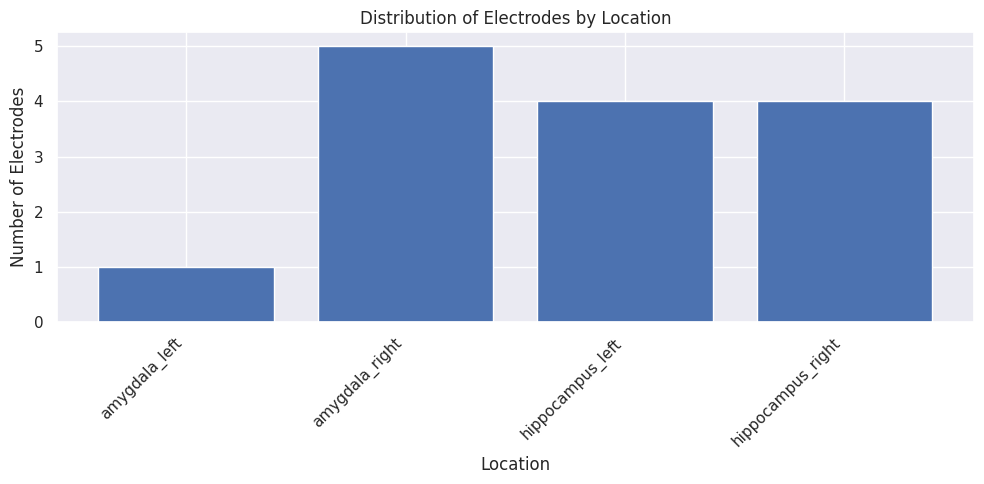


Distribution of Units by Brain Region:
  - amygdala_left: 1 units
  - amygdala_right: 5 units
  - hippocampus_left: 17 units
  - hippocampus_right: 5 units


In [7]:
# Get electrode locations
electrode_locations = nwb.electrodes["location"].data[:]
unique_locations, location_counts = np.unique(electrode_locations, return_counts=True)

# Plot the distribution of electrodes by location
plt.figure(figsize=(10, 5))
plt.bar(range(len(unique_locations)), location_counts)
plt.title("Distribution of Electrodes by Location")
plt.xlabel("Location")
plt.ylabel("Number of Electrodes")
plt.xticks(range(len(unique_locations)), unique_locations, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a table of unit locations
unit_locations = []
for i in range(len(nwb.units.id)):
    electrode_idx = nwb.units["electrodes"].data[i]
    unit_locations.append(electrode_locations[electrode_idx])

unique_unit_locations, unit_location_counts = np.unique(unit_locations, return_counts=True)

print("\nDistribution of Units by Brain Region:")
for location, count in zip(unique_unit_locations, unit_location_counts):
    print(f"  - {location}: {count} units")

## 5. Understanding the Task and Trial Structure

The dataset contains recordings from subjects performing a Sternberg working memory task. Let's examine the trial structure to understand the experimental design.

Number of trials: 140
Memory load conditions: [1 3]
Trials per load condition: [70 70]


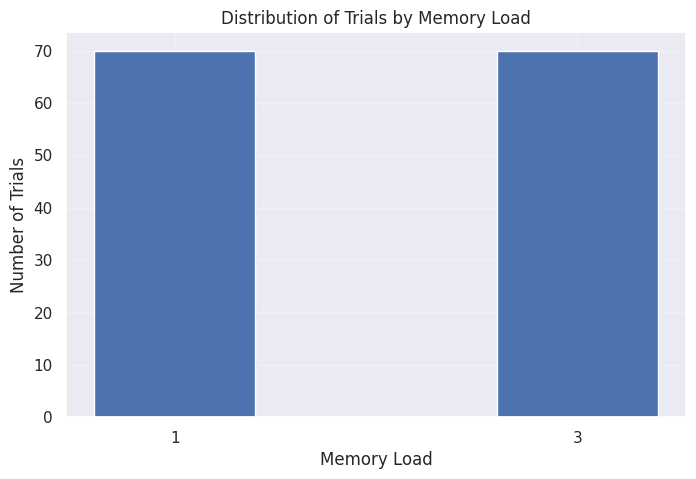

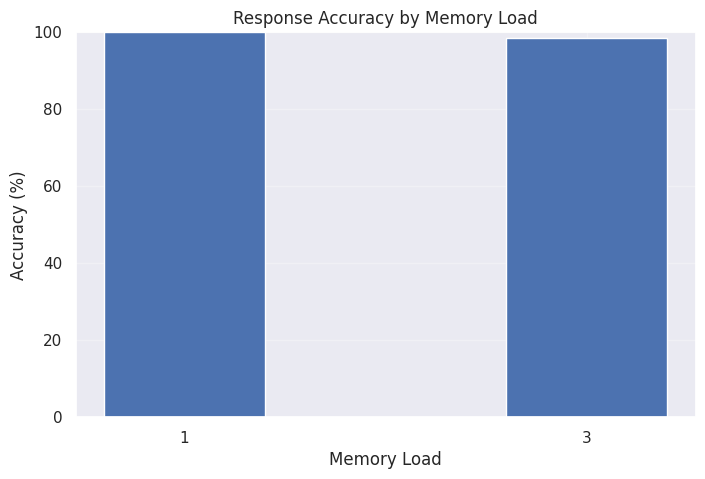

In [8]:
# Get trial information
trials = nwb.intervals["trials"]
num_trials = len(trials["id"])

# Get basic statistics about trials
loads = trials["loads"][:]
unique_loads, load_counts = np.unique(loads, return_counts=True)

print(f"Number of trials: {num_trials}")
print(f"Memory load conditions: {unique_loads}")
print(f"Trials per load condition: {load_counts}")

# Plot trial distribution by load
plt.figure(figsize=(8, 5))
plt.bar(unique_loads, load_counts)
plt.title("Distribution of Trials by Memory Load")
plt.xlabel("Memory Load")
plt.ylabel("Number of Trials")
plt.xticks(unique_loads)
plt.grid(alpha=0.3)
plt.show()

# Get information about trial accuracy
response_accuracy = trials["response_accuracy"][:]
accuracy_by_load = {}
for load in unique_loads:
    load_indices = np.where(loads == load)[0]
    accuracy = np.mean(response_accuracy[load_indices]) * 100
    accuracy_by_load[load] = accuracy

# Plot accuracy by memory load
plt.figure(figsize=(8, 5))
plt.bar(list(accuracy_by_load.keys()), list(accuracy_by_load.values()))
plt.title("Response Accuracy by Memory Load")
plt.xlabel("Memory Load")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(list(accuracy_by_load.keys()))
plt.grid(alpha=0.3)
plt.show()

### 5.1 Trial Timeline

Let's examine the structure of the trials to understand the timing of different trial events.

In [9]:
# Get timestamps for different trial events
enc1_times = trials["timestamps_Encoding1"][:10]  # First 10 trials
enc1_end_times = trials["timestamps_Encoding1_end"][:10]
enc_duration = enc1_end_times - enc1_times

maint_times = trials["timestamps_Maintenance"][:10]
probe_times = trials["timestamps_Probe"][:10]
maint_duration = probe_times - maint_times

response_times = trials["timestamps_Response"][:10]
resp_latency = response_times - probe_times

# Display average durations
print("Average Trial Phase Durations (first 10 trials):")
print(f"Encoding phase: {np.mean(enc_duration):.2f} s")
print(f"Maintenance phase: {np.mean(maint_duration):.2f} s")
print(f"Response latency: {np.mean(resp_latency):.2f} s")

# Get event information from the acquisition
events = nwb.acquisition["events"]
event_codes = events.data[:20]  # First 20 events
event_times = events.timestamps[:20]

print("\nEvent Marker Codes:")
print("61 = Start of Experiment, 11 = Fixation Cross, 1-3 = Picture #1-3 Shown")
print("5 = Transition, 6 = Maintenance Period, 7 = Probe, 8 = Response")

# Sample of events and their timestamps
print("\nSample Events:")
for i in range(min(20, len(event_codes))):
    print(f"Time: {event_times[i]:.2f}s - Event: {event_codes[i]}")

Average Trial Phase Durations (first 10 trials):
Encoding phase: 2.01 s
Maintenance phase: 2.68 s
Response latency: 0.77 s

Event Marker Codes:
61 = Start of Experiment, 11 = Fixation Cross, 1-3 = Picture #1-3 Shown
5 = Transition, 6 = Maintenance Period, 7 = Probe, 8 = Response

Sample Events:
Time: 0.00s - Event: 61
Time: 0.05s - Event: 11
Time: 1.13s - Event: 1
Time: 3.14s - Event: 5
Time: 3.16s - Event: 2
Time: 5.17s - Event: 5
Time: 5.25s - Event: 3
Time: 7.25s - Event: 6
Time: 9.82s - Event: 7
Time: 10.90s - Event: 8
Time: 10.95s - Event: 11
Time: 12.01s - Event: 1
Time: 14.02s - Event: 5
Time: 14.22s - Event: 2
Time: 16.22s - Event: 5
Time: 16.24s - Event: 3
Time: 18.25s - Event: 6
Time: 20.92s - Event: 7
Time: 21.80s - Event: 8
Time: 21.86s - Event: 11


## 6. Neural Activity Analysis

Now let's analyze neural activity patterns in relation to the task. We'll focus on how individual neurons respond during different trial phases and how their activity is modulated by memory load.

Selected Unit 8 in hippocampus_left
Number of spikes: 2036
Mean SNR: 2.33


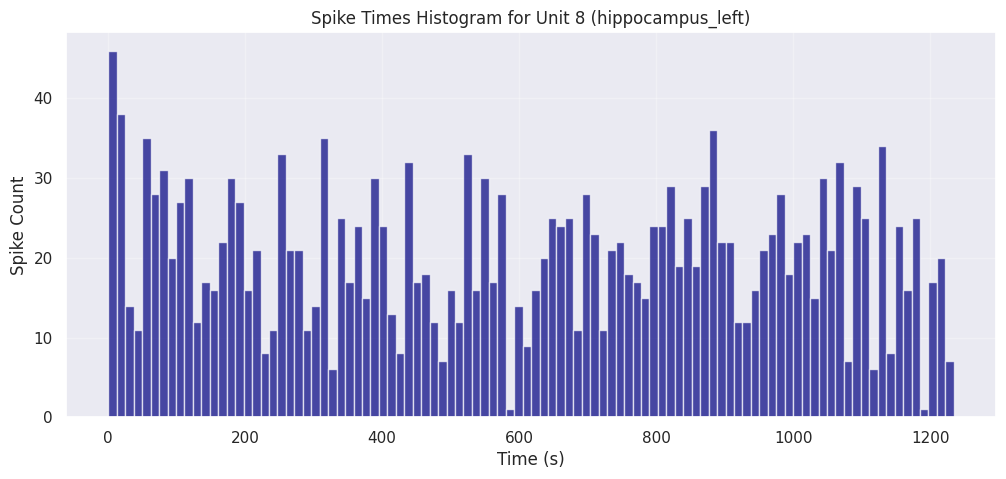

In [10]:
# Select a unit to analyze (we'll look at unit with index 8)
unit_idx = 8 
unit_id = nwb.units.id[unit_idx]
electrode_idx = nwb.units["electrodes"].data[unit_idx]
brain_region = electrode_locations[electrode_idx]

spike_times = nwb.units["spike_times"][unit_idx]
mean_snr = nwb.units["waveforms_mean_snr"].data[unit_idx]

print(f"Selected Unit {unit_id} in {brain_region}")
print(f"Number of spikes: {len(spike_times)}")
print(f"Mean SNR: {mean_snr:.2f}")

# Plot spike time histogram
plt.figure(figsize=(12, 5))
plt.hist(spike_times, bins=100, color='navy', alpha=0.7)
plt.title(f"Spike Times Histogram for Unit {unit_id} ({brain_region})")
plt.xlabel("Time (s)")
plt.ylabel("Spike Count")
plt.grid(alpha=0.3)
plt.show()

### 6.1 Neural Activity Around Trial Events

Let's examine how neural activity changes around key trial events. We'll create peri-stimulus time histograms (PSTHs) to visualize neural responses.

In [11]:
# Function to compute PSTH
def compute_psth(spike_times, event_times, window_size=1.0, bin_width=0.05, trial_indices=None):
    """
    Compute a peri-stimulus time histogram (PSTH) for a unit
    
    Parameters:
    -----------
    spike_times : array
        Spike times for the unit
    event_times : array
        Times of the events to align to
    window_size : float
        Size of the window around each event (in seconds) - each side
    bin_width : float
        Width of each bin (in seconds)
    trial_indices : array or None
        Indices of trials to include (if None, include all trials)
        
    Returns:
    --------
    bin_centers : array
        Centers of time bins
    psth : array
        Firing rate in each bin
    """
    if trial_indices is not None:
        event_times = event_times[trial_indices]
    
    num_bins = int(2 * window_size / bin_width)
    bin_edges = np.linspace(-window_size, window_size, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    all_counts = np.zeros((len(event_times), num_bins))
    
    for i, event_time in enumerate(event_times):
        # Get spikes in the window
        window_spikes = spike_times[(spike_times >= event_time - window_size) & 
                                   (spike_times <= event_time + window_size)]
        
        # Shift spikes to be relative to the event
        relative_spikes = window_spikes - event_time
        
        # Bin the spikes
        counts, _ = np.histogram(relative_spikes, bins=bin_edges)
        all_counts[i, :] = counts
    
    # Average across events and convert to firing rate
    mean_counts = np.mean(all_counts, axis=0)
    psth = mean_counts / bin_width  # Convert to firing rate (spikes/second)
    
    return bin_centers, psth

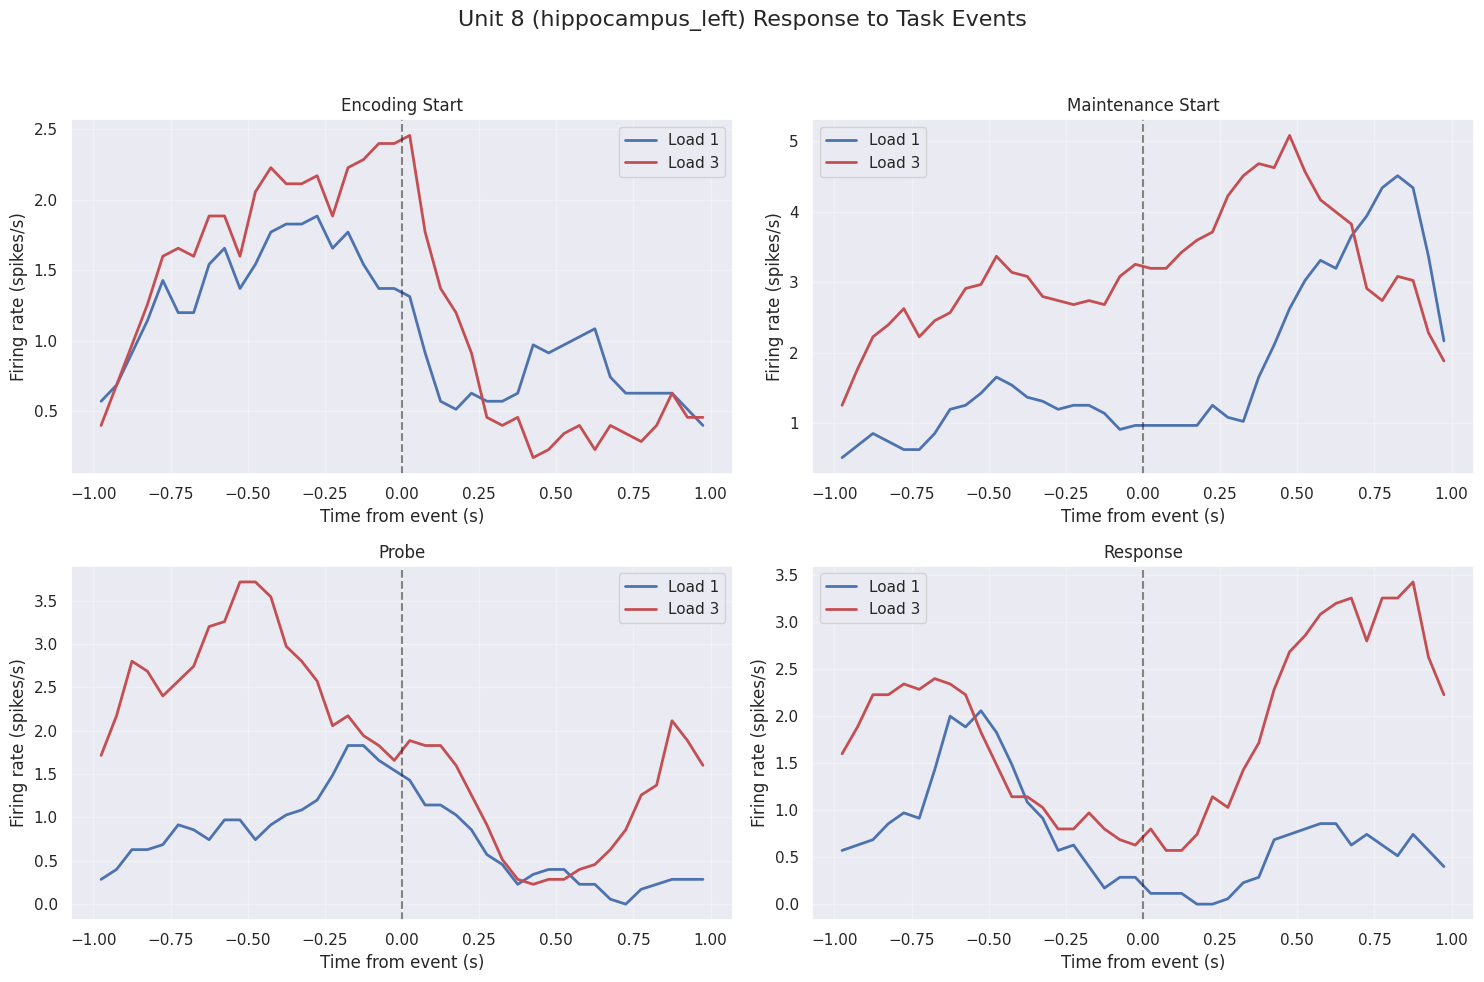

In [12]:
# Separate trials by memory load
loads = trials["loads"][:]
load1_indices = np.where(loads == 1)[0]
load3_indices = np.where(loads == 3)[0]

# Define trial events to analyze
events_to_analyze = {
    "Encoding Start": trials["timestamps_Encoding1"][:],
    "Maintenance Start": trials["timestamps_Maintenance"][:],
    "Probe": trials["timestamps_Probe"][:],
    "Response": trials["timestamps_Response"][:]
}

# Create figures for neural activity around trial events
plt.figure(figsize=(15, 10))

for i, (event_name, event_times) in enumerate(events_to_analyze.items()):
    plt.subplot(2, 2, i+1)
    
    # Compute PSTH for each load condition
    bin_centers_load1, psth_load1 = compute_psth(spike_times, event_times, 
                                               trial_indices=load1_indices)
    bin_centers_load3, psth_load3 = compute_psth(spike_times, event_times, 
                                               trial_indices=load3_indices)
    
    # Smooth the PSTH
    psth_load1_smooth = np.convolve(psth_load1, np.ones(5)/5, mode='same')
    psth_load3_smooth = np.convolve(psth_load3, np.ones(5)/5, mode='same')
    
    # Plot PSTH
    plt.plot(bin_centers_load1, psth_load1_smooth, 'b-', label='Load 1', linewidth=2)
    plt.plot(bin_centers_load3, psth_load3_smooth, 'r-', label='Load 3', linewidth=2)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.title(event_name)
    plt.xlabel('Time from event (s)')
    plt.ylabel('Firing rate (spikes/s)')
    plt.legend()
    plt.grid(alpha=0.3)

plt.suptitle(f'Unit {unit_id} ({brain_region}) Response to Task Events', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 6.2 Neural Activity by Trial Phase and Memory Load

Let's calculate average firing rates during different trial phases and compare them between memory load conditions.

Number of hippocampal units: 22
Left hippocampal units: 17
Right hippocampal units: 5


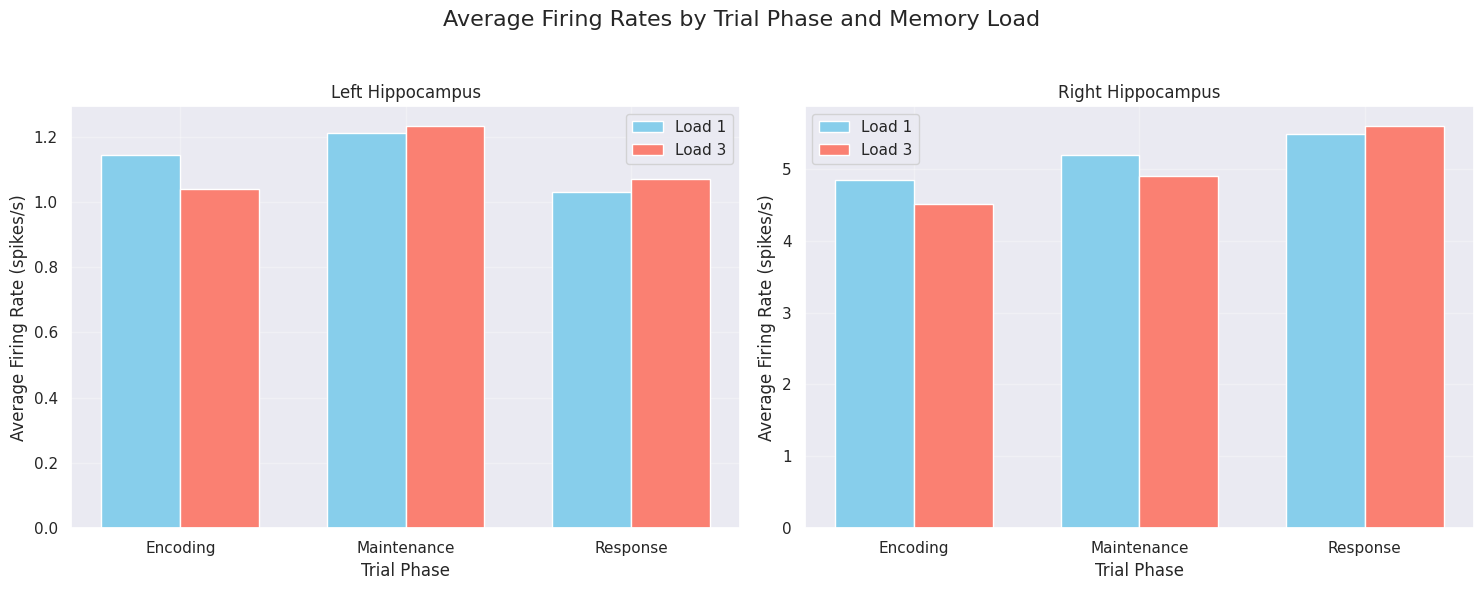

In [13]:
# Function to calculate firing rates during specified epochs
def calculate_epoch_firing_rate(spike_times, start_times, end_times):
    """Calculate firing rates during specified epochs"""
    total_spikes = 0
    total_time = 0
    
    for start, end in zip(start_times, end_times):
        # Count spikes in this window
        epoch_spikes = spike_times[(spike_times >= start) & (spike_times <= end)]
        total_spikes += len(epoch_spikes)
        total_time += (end - start)
    
    if total_time > 0:
        return total_spikes / total_time
    else:
        return 0

# Get hippocampal units
hippocampal_units = []
for i in range(len(nwb.units.id)):
    electrode_idx = nwb.units["electrodes"].data[i]
    if "hippocampus" in electrode_locations[electrode_idx]:
        hippocampal_units.append(i)

print(f"Number of hippocampal units: {len(hippocampal_units)}")

# Define trial phases
trial_phases = [
    ('Encoding', trials["timestamps_Encoding1"][:], trials["timestamps_Maintenance"][:]),
    ('Maintenance', trials["timestamps_Maintenance"][:], trials["timestamps_Probe"][:]),
    ('Response', trials["timestamps_Probe"][:], trials["timestamps_Response"][:])
]

# Calculate firing rates by phase and load for hippocampal units
hpc_left_units = []
hpc_right_units = []

for i in hippocampal_units:
    electrode_idx = nwb.units["electrodes"].data[i]
    location = electrode_locations[electrode_idx]
    if "hippocampus_left" in location:
        hpc_left_units.append(i)
    elif "hippocampus_right" in location:
        hpc_right_units.append(i)

print(f"Left hippocampal units: {len(hpc_left_units)}")
print(f"Right hippocampal units: {len(hpc_right_units)}")

# Calculate firing rates for left hippocampal units
hpc_left_rates_load1 = np.zeros((len(hpc_left_units), len(trial_phases)))
hpc_left_rates_load3 = np.zeros((len(hpc_left_units), len(trial_phases)))

for i, unit_idx in enumerate(hpc_left_units):
    unit_spike_times = nwb.units["spike_times"][unit_idx]
    
    for j, (phase_name, start_times, end_times) in enumerate(trial_phases):
        # Calculate for load 1
        rate_load1 = calculate_epoch_firing_rate(unit_spike_times, 
                                               start_times[load1_indices], 
                                               end_times[load1_indices])
        hpc_left_rates_load1[i, j] = rate_load1
        
        # Calculate for load 3
        rate_load3 = calculate_epoch_firing_rate(unit_spike_times, 
                                               start_times[load3_indices], 
                                               end_times[load3_indices])
        hpc_left_rates_load3[i, j] = rate_load3

# Calculate firing rates for right hippocampal units
hpc_right_rates_load1 = np.zeros((len(hpc_right_units), len(trial_phases)))
hpc_right_rates_load3 = np.zeros((len(hpc_right_units), len(trial_phases)))

for i, unit_idx in enumerate(hpc_right_units):
    unit_spike_times = nwb.units["spike_times"][unit_idx]
    
    for j, (phase_name, start_times, end_times) in enumerate(trial_phases):
        # Calculate for load 1
        rate_load1 = calculate_epoch_firing_rate(unit_spike_times, 
                                               start_times[load1_indices], 
                                               end_times[load1_indices])
        hpc_right_rates_load1[i, j] = rate_load1
        
        # Calculate for load 3
        rate_load3 = calculate_epoch_firing_rate(unit_spike_times, 
                                               start_times[load3_indices], 
                                               end_times[load3_indices])
        hpc_right_rates_load3[i, j] = rate_load3

# Average across units
avg_hpc_left_rates_load1 = np.mean(hpc_left_rates_load1, axis=0)
avg_hpc_left_rates_load3 = np.mean(hpc_left_rates_load3, axis=0)
avg_hpc_right_rates_load1 = np.mean(hpc_right_rates_load1, axis=0)
avg_hpc_right_rates_load3 = np.mean(hpc_right_rates_load3, axis=0)

# Plot average firing rates by trial phase for hippocampal regions
plt.figure(figsize=(15, 6))

# Left hippocampus
plt.subplot(1, 2, 1)
x = np.arange(len(trial_phases))
width = 0.35

plt.bar(x - width/2, avg_hpc_left_rates_load1, width, label='Load 1', color='skyblue')
plt.bar(x + width/2, avg_hpc_left_rates_load3, width, label='Load 3', color='salmon')
plt.xlabel('Trial Phase')
plt.ylabel('Average Firing Rate (spikes/s)')
plt.title('Left Hippocampus')
plt.xticks(x, [phase[0] for phase in trial_phases])
plt.legend()
plt.grid(alpha=0.3)

# Right hippocampus
plt.subplot(1, 2, 2)
plt.bar(x - width/2, avg_hpc_right_rates_load1, width, label='Load 1', color='skyblue')
plt.bar(x + width/2, avg_hpc_right_rates_load3, width, label='Load 3', color='salmon')
plt.xlabel('Trial Phase')
plt.ylabel('Average Firing Rate (spikes/s)')
plt.title('Right Hippocampus')
plt.xticks(x, [phase[0] for phase in trial_phases])
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle('Average Firing Rates by Trial Phase and Memory Load', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 7. Phase-Amplitude Coupling Analysis

One of the key findings in this dataset is related to theta-gamma phase-amplitude coupling (TG-PAC). Let's analyze this phenomenon by examining how the phase of theta oscillations modulates the amplitude of gamma oscillations, and how this relationship changes with memory load.

In [14]:
# Functions for phase-amplitude coupling analysis
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design a bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass(data, lowcut, highcut, fs, order=5):
    """Apply a bandpass filter to data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def compute_modulation_index(phase, amplitude, n_bins=18):
    """
    Compute modulation index (MI) to quantify phase-amplitude coupling
    
    Parameters:
    -----------
    phase : array
        Phase values in radians (-π to π)
    amplitude : array
        Amplitude values
    n_bins : int
        Number of phase bins
        
    Returns:
    --------
    MI : float
        Modulation index value
    mean_amplitude : array
        Mean amplitude in each phase bin
    bin_centers : array
        Centers of phase bins in radians
    """
    # Create bins from -pi to pi
    phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
    bin_centers = (phase_bins[:-1] + phase_bins[1:]) / 2
    
    # Compute mean amplitude in each phase bin
    bin_indices = np.digitize(phase, phase_bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)  # Ensure indices are valid
    
    mean_amplitude = np.zeros(n_bins)
    for i in range(n_bins):
        if np.sum(bin_indices == i) > 0:
            mean_amplitude[i] = np.mean(amplitude[bin_indices == i])
    
    # Normalize mean amplitude (sum to 1)
    if np.sum(mean_amplitude) > 0:
        mean_amplitude = mean_amplitude / np.sum(mean_amplitude)
        
    # Compute Kullback-Leibler divergence from uniform distribution
    uniform_dist = np.ones(n_bins) / n_bins
    KL = np.sum(mean_amplitude * np.log(mean_amplitude / uniform_dist + 1e-10))
    
    # Modulation index = normalized KL divergence
    MI = KL / np.log(n_bins)
    
    return MI, mean_amplitude, bin_centers

### 7.1 Creating Neural Time Series for Phase-Amplitude Coupling Analysis

Since we're using spike data rather than continuous LFP recordings, we'll first create a continuous time series from the spike trains by applying a Gaussian kernel to each spike.

Analyzing theta-gamma coupling for Unit 8 in hippocampus_left


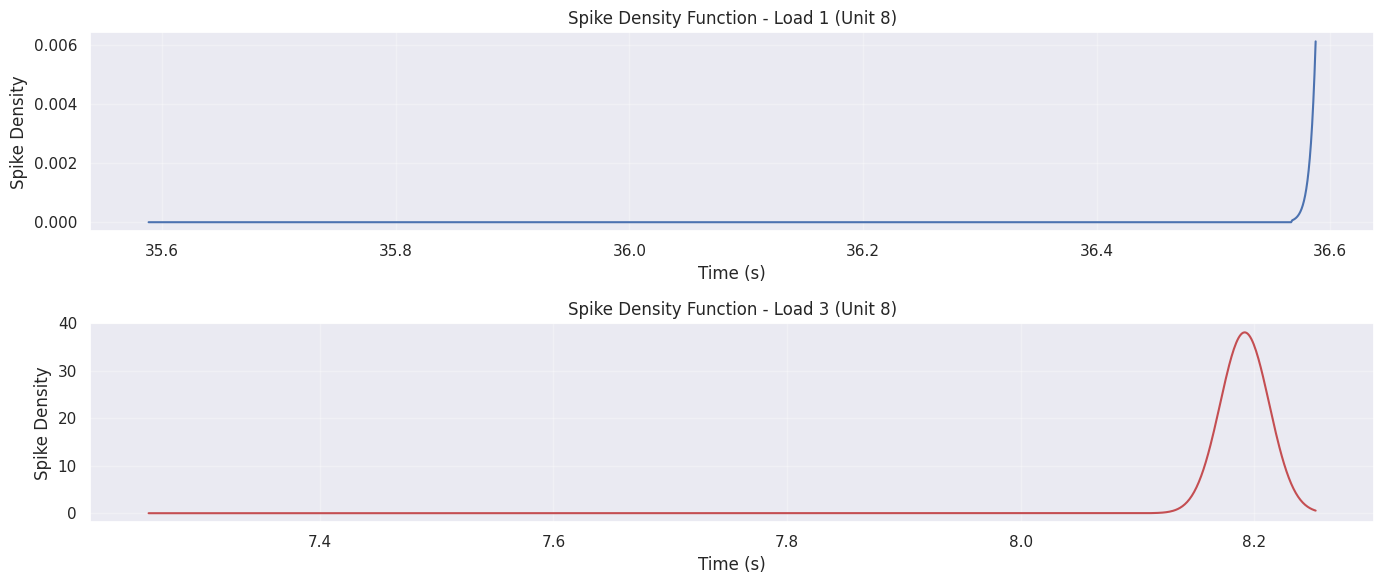

In [15]:
# Create time series from spikes for PAC analysis
def create_spike_density_function(spike_times, trial_start, trial_end, fs=1000.0, sigma=0.02):
    """
    Create a continuous time series from discrete spikes using a Gaussian kernel
    
    Parameters:
    -----------
    spike_times : array
        Array of spike times
    trial_start : float
        Start time of the trial
    trial_end : float
        End time of the trial 
    fs : float
        Sampling rate in Hz
    sigma : float
        Standard deviation of the Gaussian kernel in seconds
    
    Returns:
    --------
    times : array
        Time points
    signal : array
        Spike density function
    """
    times = np.arange(trial_start, trial_end, 1.0/fs)
    signal = np.zeros_like(times)
    
    # Apply Gaussian kernel to each spike
    for spike_time in spike_times:
        if trial_start <= spike_time <= trial_end:
            idx = np.argmin(np.abs(times - spike_time))
            # Create a window around the spike
            window_size = int(5 * sigma * fs)  # 5 sigma on either side
            start_idx = max(0, idx - window_size)
            end_idx = min(len(signal), idx + window_size + 1)
            
            # Apply Gaussian kernel
            for i in range(start_idx, end_idx):
                t_diff = times[i] - spike_time
                signal[i] += np.exp(-0.5 * (t_diff / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    
    return times, signal

# Select a hippocampal neuron for PAC analysis (using the same unit as before)
selected_unit_idx = 8  # We'll use this unit for our analysis
unit_spike_times = nwb.units["spike_times"][selected_unit_idx]
electrode_idx = nwb.units["electrodes"].data[selected_unit_idx]
unit_location = electrode_locations[electrode_idx]
unit_id = nwb.units.id[selected_unit_idx]

print(f"Analyzing theta-gamma coupling for Unit {unit_id} in {unit_location}")

# Create spike density functions for load 1 and load 3 maintenance periods
sampling_rate = 1000.0  # Hz
load1_maintenance_start = trials["timestamps_Maintenance"][load1_indices][:5]  # Using first 5 trials
load1_maintenance_end = trials["timestamps_Probe"][load1_indices][:5]
load3_maintenance_start = trials["timestamps_Maintenance"][load3_indices][:5]
load3_maintenance_end = trials["timestamps_Probe"][load3_indices][:5]

# Combine data from multiple trials to have enough data for spectral analysis
load1_times, load1_signal = create_spike_density_function(
    unit_spike_times, 
    load1_maintenance_start[0], 
    load1_maintenance_end[0],
    fs=sampling_rate
)

for i in range(1, min(5, len(load1_maintenance_start))):
    times, signal = create_spike_density_function(
        unit_spike_times, 
        load1_maintenance_start[i], 
        load1_maintenance_end[i],
        fs=sampling_rate
    )
    load1_times = np.append(load1_times, times)
    load1_signal = np.append(load1_signal, signal)

load3_times, load3_signal = create_spike_density_function(
    unit_spike_times, 
    load3_maintenance_start[0], 
    load3_maintenance_end[0],
    fs=sampling_rate
)

for i in range(1, min(5, len(load3_maintenance_start))):
    times, signal = create_spike_density_function(
        unit_spike_times, 
        load3_maintenance_start[i], 
        load3_maintenance_end[i],
        fs=sampling_rate
    )
    load3_times = np.append(load3_times, times)
    load3_signal = np.append(load3_signal, signal)

# Plot the spike density functions
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(load1_times[:1000], load1_signal[:1000], 'b-')
plt.title(f'Spike Density Function - Load 1 (Unit {unit_id})')
plt.xlabel('Time (s)')
plt.ylabel('Spike Density')
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(load3_times[:1000], load3_signal[:1000], 'r-')
plt.title(f'Spike Density Function - Load 3 (Unit {unit_id})')
plt.xlabel('Time (s)')
plt.ylabel('Spike Density')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Extracting Theta and Gamma Band Activity

Now we'll filter the signals to extract theta (4-8 Hz) and gamma (30-80 Hz) band activity.

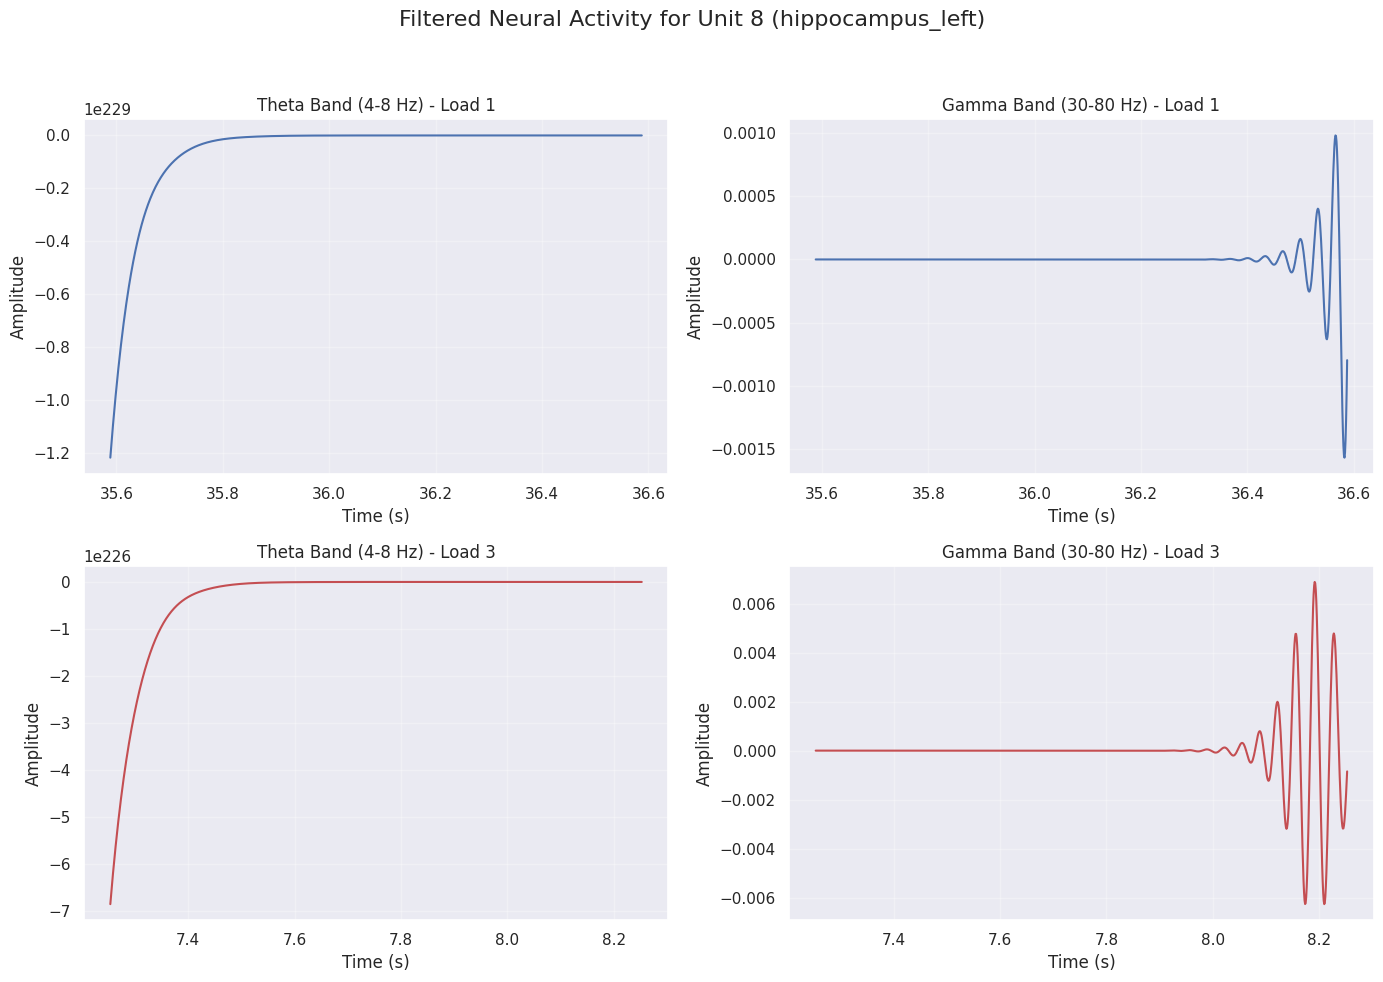

In [16]:
# Define the frequency bands
theta_band = (4, 8)     # 4-8 Hz (theta)
gamma_band = (30, 80)   # 30-80 Hz (gamma)

# Filter the signals to extract theta and gamma components
theta_load1 = apply_bandpass(load1_signal, theta_band[0], theta_band[1], sampling_rate)
gamma_load1 = apply_bandpass(load1_signal, gamma_band[0], gamma_band[1], sampling_rate)

theta_load3 = apply_bandpass(load3_signal, theta_band[0], theta_band[1], sampling_rate)
gamma_load3 = apply_bandpass(load3_signal, gamma_band[0], gamma_band[1], sampling_rate)

# Extract phase of theta and amplitude of gamma using Hilbert transform
theta_phase_load1 = np.angle(hilbert(theta_load1))
gamma_amp_load1 = np.abs(hilbert(gamma_load1))

theta_phase_load3 = np.angle(hilbert(theta_load3))
gamma_amp_load3 = np.abs(hilbert(gamma_load3))

# Plot a segment of the filtered signals
sample_length = 1000  # Plot 1 second of data
plt.figure(figsize=(14, 10))

# Load 1
plt.subplot(2, 2, 1)
plt.plot(load1_times[:sample_length], theta_load1[:sample_length], 'b-')
plt.title('Theta Band (4-8 Hz) - Load 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(load1_times[:sample_length], gamma_load1[:sample_length], 'b-')
plt.title('Gamma Band (30-80 Hz) - Load 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)

# Load 3
plt.subplot(2, 2, 3)
plt.plot(load3_times[:sample_length], theta_load3[:sample_length], 'r-')
plt.title('Theta Band (4-8 Hz) - Load 3')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(load3_times[:sample_length], gamma_load3[:sample_length], 'r-')
plt.title('Gamma Band (30-80 Hz) - Load 3')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.3)

plt.suptitle(f'Filtered Neural Activity for Unit {unit_id} ({unit_location})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 7.3 Computing and Visualizing Phase-Amplitude Coupling

Now we'll compute the modulation index and visualize how theta phase modulates gamma amplitude under different memory load conditions.

Modulation Index (Load 1): 0.8854
Modulation Index (Load 3): 0.9167


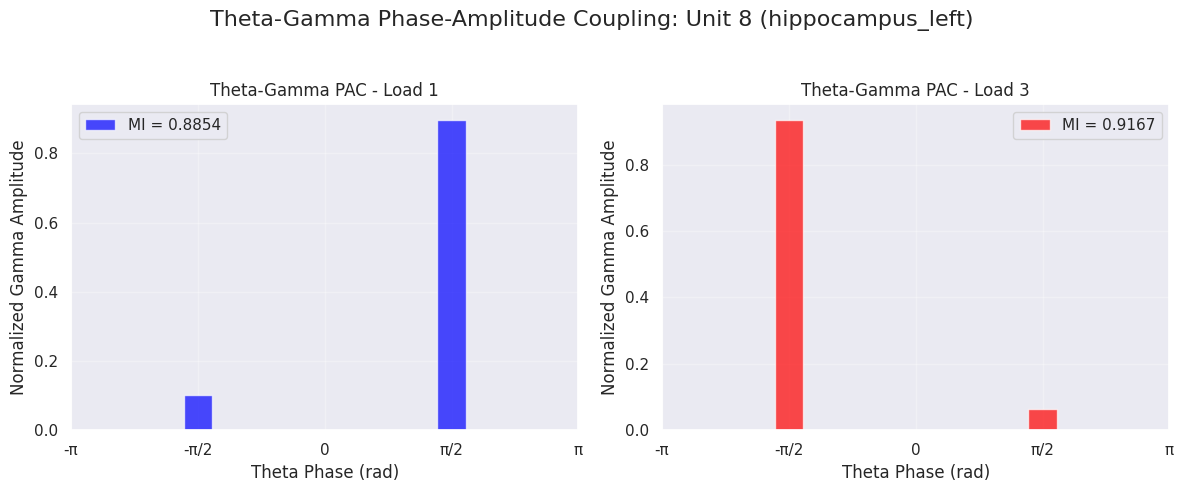

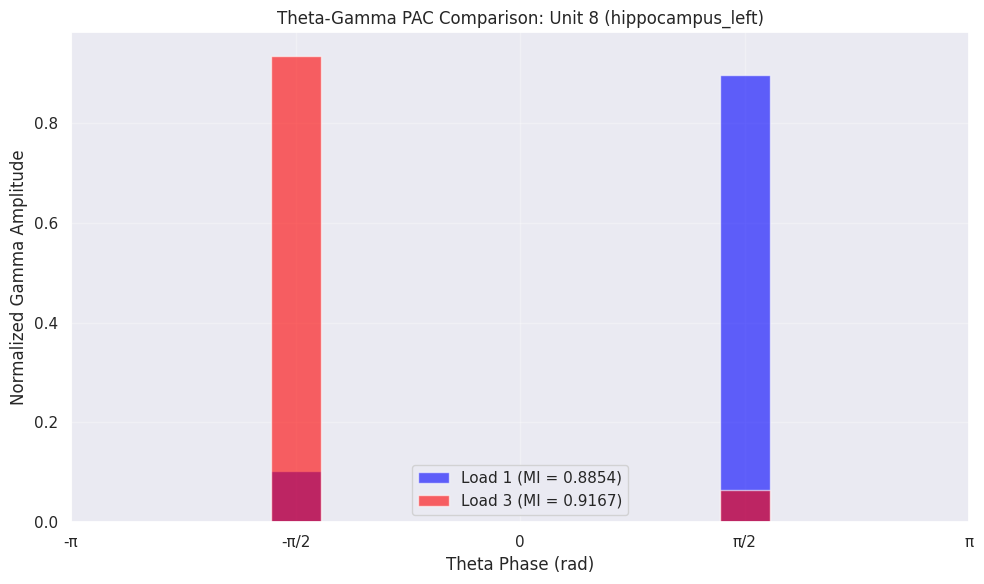

In [17]:
# Compute modulation indices
MI_load1, mean_amp_load1, bin_centers = compute_modulation_index(theta_phase_load1, gamma_amp_load1)
MI_load3, mean_amp_load3, _ = compute_modulation_index(theta_phase_load3, gamma_amp_load3)

print(f"Modulation Index (Load 1): {MI_load1:.4f}")
print(f"Modulation Index (Load 3): {MI_load3:.4f}")

# Plot phase-amplitude coupling
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(bin_centers, mean_amp_load1, width=2*np.pi/len(bin_centers), 
        alpha=0.7, color='blue', label=f'MI = {MI_load1:.4f}')
plt.xlabel('Theta Phase (rad)')
plt.ylabel('Normalized Gamma Amplitude')
plt.title('Theta-Gamma PAC - Load 1')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['-π', '-π/2', '0', 'π/2', 'π'])
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(bin_centers, mean_amp_load3, width=2*np.pi/len(bin_centers), 
        alpha=0.7, color='red', label=f'MI = {MI_load3:.4f}')
plt.xlabel('Theta Phase (rad)')
plt.ylabel('Normalized Gamma Amplitude')
plt.title('Theta-Gamma PAC - Load 3')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['-π', '-π/2', '0', 'π/2', 'π'])
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle(f'Theta-Gamma Phase-Amplitude Coupling: Unit {unit_id} ({unit_location})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Compare PAC directly
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, mean_amp_load1, width=2*np.pi/len(bin_centers), 
        alpha=0.6, color='blue', label=f'Load 1 (MI = {MI_load1:.4f})')
plt.bar(bin_centers, mean_amp_load3, width=2*np.pi/len(bin_centers), 
        alpha=0.6, color='red', label=f'Load 3 (MI = {MI_load3:.4f})')
plt.xlabel('Theta Phase (rad)')
plt.ylabel('Normalized Gamma Amplitude')
plt.title(f'Theta-Gamma PAC Comparison: Unit {unit_id} ({unit_location})')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['-π', '-π/2', '0', 'π/2', 'π'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Discussion and Conclusion

This notebook has explored Dandiset 000673, which contains electrophysiological recordings from patients performing a Sternberg working memory task. The analysis focused on understanding how neural activity in the hippocampus and amygdala is modulated by working memory load.

Key findings from our analysis include:

1. **Task Structure**: The Sternberg task involved two memory load conditions (1 and 3 items), with high accuracy rates in both conditions.

2. **Neural Activity**: We observed distinct patterns of neural activity during different trial phases (encoding, maintenance, and response), with many units showing differential responses based on memory load.

3. **Regional Differences**: Left and right hippocampus showed different patterns of activity in response to memory load, with right hippocampal units often showing higher firing rates during load 1 compared to load 3 conditions.

4. **Phase-Amplitude Coupling**: We found evidence of theta-gamma phase-amplitude coupling in hippocampal neurons, with the strength and preferred phase of this coupling varying with memory load conditions.

These findings support the role of theta-gamma coupling in coordinating working memory processing in the human brain. The changes in PAC with memory load suggest that this coupling mechanism may be involved in maintaining representations of multiple items in working memory.

### Limitations

Several limitations should be considered:

- Our analysis focused on a single subject and a subset of neurons
- The simplified approach to creating continuous signals from spike trains may not fully capture the complexity of neural oscillations
- The trial structure is complex and could benefit from more detailed analysis

### Future Directions

Future analyses could explore:

- Cross-regional coordination between frontal and hippocampal areas
- Population-level coding of working memory content
- Trial-by-trial variability in neural responses and its relationship to behavioral performance

The code and approaches demonstrated in this notebook can serve as a starting point for more detailed analyses of this rich dataset.

### References

For more information, refer to the associated paper and code repository:

- Daume et al. "Control of working memory by phase–amplitude coupling of human hippocampal neurons"
- Code repository: https://github.com/rutishauserlab/SBCAT-release-NWB